In [2]:
%load_ext autoreload
%autoreload 2

from cache import *
from costs import *
from features import *
from helpers import *
from evaluate import *
from predict import *
from validate import *
from implementations import *

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
SUB_SAMPLE = False
CACHE_DIR = "test/cache/" if SUB_SAMPLE else "cache/"
SUBMISSIONS_DIR = "test/submissions/" if SUB_SAMPLE else "submissions/"

y, x, ids = load_csv_data('data/train.csv', SUB_SAMPLE)

# 1 - Analytical Results

### Ridge Regression with Fixed Degree

##### Without Validation

In [ ]:
def clean_standardize_expand(y, x, h):
        
    degree = int(h['degree'])

    x = remove_errors(x)
    x = remove_outliers(x)
    x = standardize_all(x)
    x = remove_nan_features(x)
    x = build_poly(x, degree)

    return y, x

def ridge_regression_analytical(y, x, h):

    lambda_ = float(h['lambda'])
    degree = int(h['degree'])

    w = ridge_regression(y, x, lambda_)
    
    return {
        'w': w,
        'mse': compute_mse(y, x, w)
    }

def ridge_mse(y, x, w, h):

    lambda_ = float(h['lambda'])
    
    mse = compute_mse(y, x, w)
    ridge_norm = np.linalg.norm(w, 2) * lambda_
        
    return {
        'mse': mse,
        'ridge_norm': ridge_norm,
        'total_loss': mse + ridge_norm,
        'n_err': compute_error_count(predict_values)(y, x, w)
    }
    

In [ ]:
hs = { 
    'degree': [5, 6, 7], 
    'lambda': 1e-4,
}

_ = evaluate(
    clean = clean_standardize_expand, 
    fit   = ridge_regression_analytical, 
    x     = x, 
    y     = y, 
    hs    = hs, 
    cache = CACHE_DIR + 'clean_standardize_expand_ridge_regression_analytical'
)

##### Using Cross-Validation

Here, we implement the same model with cross-validation.

In [ ]:
hs = { 
    'degree': np.arange(4, 16), 
    'lambda': np.logspace(-8, -4, 5),
    'k_fold': 4,
    'seed': 0
}

def mse(y, x, w):
    return { 'mse' : compute_mse(y, x, w) }



evaluate(
    clean = cross_validate(ridge_regression_analytical, mse), 
    fit   = fit_function, 
    x     = x,
    y     = y, 
    hs    = hs, 
    cache = CACHE_DIR + 'clean_standardize_expand_cross_validate_ridge_regression_analytical_mse'
)

In [ ]:
# myModel.predict(best_h, x, y, SUBMISSIONS_DIR + 'RidgeRegression_MSE_FixedDegree_CrossValidation_Model')

## Gradient Descents

#### Least Square

#### Ridge Regression

#### Lasso

# Logistic Regression

In [ ]:
def map_logistic(clean):
    
    def inner_function(y, x, h):
        y, x = clean(y, x, h)
        y = np.where(y == 1, 1, 0)
        return y, x
    
    return inner_function

def logistic_gradient(y, x, w, h):
    
    return compute_logistic_gradient(y, x, w)
            


def logistic_gradient_ridge(y, x, w, h):
    
    lambda_ = h['lambda']
    
    return compute_logistic_gradient(y, x, w) + lambda_ * w



def logistic_gradient_lasso(y, x, w, h):
    
    lambda_ = h['lambda']
    
    return compute_logistic_gradient(y, x, w) + lambda_ * np.sign(w)



### Without Validation

##### Stochastic Gradient Descent

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': np.concatenate([[-2], np.arange(1, 7)]),
    'gamma': [1e-2, 1e-3], 
    'k_fold': 4,
    'lambda': 0,
    'max_iters': 3000,
    'num_batches': 1,
    'seed': 1,
}

cache = Cache(CACHE_DIR + 'clean_standardize_expand_stochastic_logistic_descent')

_ = evaluate(
    clean = map_logistic(clean_standardize_expand), 
    fit   = descent_with_cache(
        descent    = descent_with_loss(stochastic_gradient_descent_e(logistic_gradient), logistic_error),  
        round_size = 100,
        cache      = cache,
        multiple   = False,
        log        = True
    ), 
    y     = y,
    x     = x,
    hs    = hs
)

###### Stochastic Gradient Descent With Ridge Regression

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': [-2] + np.arange(3, 4),
    'gamma': [1e-2, 1e-3], 
    'lambda': [1e-2, 1e-3],
    'k_fold': 4,
    'max_iters': 1000,
    'num_batches': 1,
    'seed': 1,
}

cache = Cache(CACHE_DIR + 'clean_standardize_expand_stochastic_logistic_ridge_descent')

_ = evaluate(
    clean = map_logistic(clean_standardize_expand), 
    fit   = descent_with_cache(
        descent    = stochastic_gradient_descent_e(logistic_gradient_ridge), 
        loss       = logistic_error_and_ridge, 
        round_size = 100,
        cache      = cache,
        log        = True
    ), 
    y     = y,
    x     = x,
    hs    = hs
)

##### Stochastic Gradient Descent With Lasso

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': [-2, 1, 2, 3, 4, 5, 6],
    'gamma': [1e-1, 1e-2, 1e-3], 
    'lambda': [1e-1, 1e-2, 1e-3],
    'k_fold': 4,
    'max_iters': 2000,
    'num_batches': 1,
    'seed': 0,
}

cache = Cache(CACHE_DIR + 'clean_standardize_expand_stochastic_logistic_lasso_descent')

_ = evaluate(
    clean = map_logistic(clean_standardize_expand), 
    fit   = descent_with_cache(
        descent    = stochastic_gradient_descent_e(logistic_gradient_lasso), 
        loss       = logistic_error_and_lasso, 
        round_size = 100,
        cache      = cache,
        log        = True
    ), 
    y     = y,
    x     = x,
    hs    = hs
)

### With Cross-Validation

##### Stochastic Gradient Descent

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': np.concatenate([[-2], np.arange(1, 7)]),
    'gamma': [1e-2, 1e-3], 
    'k_fold': 4,
    'lambda': 0,
    'max_iters': 3000,
    'num_batches': 1,
    'seed': 0,
    'seed_cv': 0
}

cache = Cache(CACHE_DIR + 'clean_standardize_expand_stochastic_logistic_descent_cross_validate')

_ = evaluate(
    clean = map_logistic(clean_standardize_expand), 
    fit   = descent_with_cache(
        descent    = cross_validate_descent(
            stochastic_gradient_descent_e(logistic_gradient), 
            logistic_error
        ),
        round_size = 100,
        cache      = cache,
        multiple   = True,
        log        = True
    ), 
    y     = y,
    x     = x,
    hs    = hs
)

##### Descent with Ridge

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': [-2] + np.arange(3, 4),
    'gamma': [1e-2, 1e-3], 
    'lambda': [1e-2, 1e-3],
    'k_fold': 4,
    'max_iters': 1000,
    'num_batches': 1,
    'seed': 1,
}

cache = Cache(CACHE_DIR + 'clean_standardize_expand_stochastic_logistic_ridge_descent_cross_validate')

_ = evaluate(
    clean = map_logistic(clean_standardize_expand), 
    fit   = descent_with_cache(
        descent    = cross_validate_descent(
            stochastic_gradient_descent_e(logistic_gradient_ridge), 
            logistic_error_and_ridge,
        ),
        round_size = 100,
        cache      = cache,
        log        = True
    ), 
    y     = y,
    x     = x,
    hs    = hs
)

##### Descent with Lasso

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': [-2] + np.arange(3, 4),
    'gamma': [1e-2, 1e-3], 
    'lambda': [1e-2, 1e-3],
    'k_fold': 4,
    'max_iters': 1000,
    'num_batches': 1,
    'seed': 1,
}

cache = Cache(CACHE_DIR + 'clean_standardize_expand_stochastic_logistic_lasso_descent_cross_validate')

_ = evaluate(
    clean = map_logistic(clean_standardize_expand), 
    fit   = descent_with_cache(
        descent    = cross_validate_descent(
            stochastic_gradient_descent_e(logistic_gradient_lasso), 
            logistic_error_and_lasso,
        ),
        round_size = 100,
        cache      = cache,
        log        = True
    ), 
    y     = y,
    x     = x,
    hs    = hs
)

# Split Dataset

### Prepare Data

In [4]:
y_split, x_split, _ = split_data(y, x, ids)

In [ ]:
hs = { 
    'degree': np.concatenate([np.array([-2]), np.arange(1, 16)]), 
    'lambda': np.logspace(-8, -4, 5),
    'k_fold': 4,
    'seed': 0
}

result = evaluate(
    clean_and_fit_with_cache(
        clean_standardize_expand, 
        cross_validate(ridge_regression_weights, mse_and_ridge),
        Cache(CACHE_DIR + f'clean_standardize_expand_cross_validate_least_squares_no_split')
    ),
    x     = x,
    y     = y, 
    hs    = hs
)
plot_heatmap(result, 'avg_mse_te', 'degree', 'lambda', 0.3)

### Least Square Ridge

In [120]:
hs = { 
    'degree': np.concatenate([np.array([-2]), np.arange(1, 16)]), 
    'lambda': np.logspace(-8, -4, 5),
    'k_fold': 4,
    'seed': 0
}



    
    
caches = [
    Cache(CACHE_DIR + f'clean_standardize_expand_cross_validate_ridge_regression_analytical_mse_split{i}')
    for i in range(5)]

#     result = evaluate(
#         clean_and_fit_with_cache(
#             clean_standardize_expand, 
#             cross_validate(ridge_regression_weights, mse_and_ridge),
#             caches[i]
#         ),
#         x     = x_split[i],
#         y     = y_split[i], 
#         hs    = hs
#     )

result = evaluate(
    clean_and_fit_with_cache(
        clean_standardize_expand, 
        cross_validate(ridge_regression_weights, mse_and_ridge),
        caches[1]
    ),
    x     = x_split[0],
    y     = y_split[0], 
    hs    = hs
)

[-0.84480605  0.04018675 -0.24586341 -0.11430458  0.15426106  0.09004544
  0.48984266 -0.03023688  0.05883171  0.0913901  -0.01782922  0.02266432
 -0.02030804  0.00870827 -0.00820178  0.11636776 -0.01287903 -0.08833822
 -0.0239281  -0.34561498]
[-0.84480605  0.04018675 -0.24586341 -0.11430458  0.15426106  0.09004544
  0.48984266 -0.03023688  0.05883171  0.0913901  -0.01782922  0.02266432
 -0.02030804  0.00870827 -0.00820178  0.11636776 -0.01287903 -0.08833822
 -0.0239281  -0.34561498]
[-0.84480605  0.04018675 -0.24586341 -0.11430458  0.15426106  0.09004544
  0.48984266 -0.03023688  0.05883171  0.0913901  -0.01782922  0.02266432
 -0.02030804  0.00870827 -0.00820178  0.11636776 -0.01287903 -0.08833822
 -0.0239281  -0.34561498]
[-0.84331554  0.02006201 -0.20559004 -0.13946504  0.12071866  0.09654746
 -2.91105602  0.06962473  0.04371174  0.89134558  0.00420434  0.03165305
  0.74973199  0.01438452 -0.00591359  0.13837462 -0.01663157 -0.10854842
  0.01893554  2.6246182 ]
[-0.84331554  0.0200

[-9.18277240e-01  6.80762298e-03  2.03038565e-02 -1.60487250e-01
 -1.36039898e-02 -2.03962805e-01  2.47510506e-02  1.01173520e-01
  2.77466943e-02  5.91234317e-02  2.63045231e-02  2.57157533e-01
 -9.03615898e-02 -2.87440381e-01  3.95285354e-02  4.55031857e-02
 -5.92381161e-05 -9.83054187e-02  2.94880272e-02 -1.85609716e-02
 -2.94475036e-02  2.10819476e-02  3.78737800e-02  2.75352340e-01
 -3.93476509e-02  1.36564045e-03 -1.65668676e-02  7.37520987e-03
  3.57409138e-02  7.51442520e-02 -1.52102296e-04 -1.84700828e-02
  5.30908369e-02  3.15719830e-04 -2.57322979e-02 -2.00072581e-01
 -7.35875070e-03  2.44584271e-01  3.81077251e-03]
[-9.18277240e-01  6.80762298e-03  2.03038565e-02 -1.60487250e-01
 -1.36039898e-02 -2.03962805e-01  2.47510506e-02  1.01173520e-01
  2.77466943e-02  5.91234317e-02  2.63045231e-02  2.57157533e-01
 -9.03615898e-02 -2.87440381e-01  3.95285354e-02  4.55031857e-02
 -5.92381161e-05 -9.83054187e-02  2.94880272e-02 -1.85609716e-02
 -2.94475036e-02  2.10819476e-02  3.7873

[-8.28681360e-01  3.07050005e-02  5.02127187e-02 -5.64273765e-03
 -7.26765524e-02 -1.33367336e-01  1.95715591e-02 -2.21703951e-01
  5.45334916e-02 -3.83803658e-03  7.60872468e-03  5.54143485e-02
  1.81534047e-02  5.94172879e-02  2.32080075e-02  4.11913854e-04
  2.06098720e-01  1.23917396e-01 -4.32235838e-02 -4.40505825e-01
  1.92618781e-02  1.04589484e-02  7.98105280e-02 -5.46124094e-02
  1.01548772e-02 -2.68329505e-01  1.30602451e-01 -1.20357716e-02
 -4.27971205e-02 -3.22162527e-02  7.53550330e-03 -2.08825072e-02
  3.22993893e-02  1.73098269e-02  3.95029227e-01 -9.82008896e-02
  6.22873823e-03  1.28468916e-02 -1.74324476e-02 -6.06609674e-03
  3.48769762e-02  1.90354688e-02 -1.56625135e-02  5.19847498e-02
 -2.95929448e-02  4.64805966e-03 -2.56204088e-02  3.15389627e-02
  4.74886091e-03 -2.31973730e-03 -6.24818312e-02  9.79423988e-03
 -2.82001166e-01 -8.43315678e-03  1.07705450e-02  4.21544670e-01
 -2.05366661e-01  3.22816480e-02]
[-8.28681360e-01  3.07050005e-02  5.02127187e-02 -5.6427

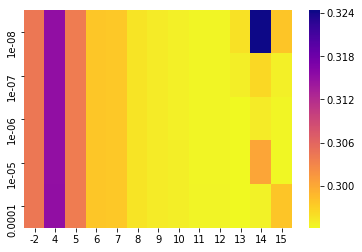

In [105]:
plot_heatmap(result, 'avg_mse_te', 'degree', 'lambda', 0.80)

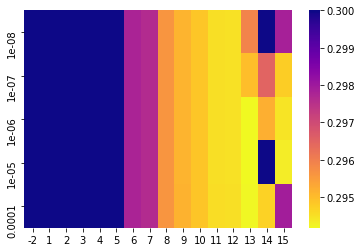

In [119]:
hs = { 
    'degree': np.concatenate([np.array([-2]), np.arange(1, 16)]), 
    'lambda': np.logspace(-8, -4, 5),
    'k_fold': 4,
    'seed': 0
}

result = evaluate(
    clean_and_fit_with_cache(
        clean_standardize_expand, 
        cross_validate(ridge_regression_weights, mse_and_ridge),
        Cache(CACHE_DIR + f'clean_standardize_expand_cross_validate_ridge_regression_analytical_mse_no_split')
    ),
    x     = x,
    y     = y, 
    hs    = hs
)
plot_heatmap(result, 'avg_mse_te', 'degree', 'lambda', 0.3)

In [85]:
find_arg_min(result, 'avg_mse_te')

{'degree': 6,
 'k_fold': 4,
 'lambda': 0.0001,
 'seed': 0,
 'avg_mse_te': 0.10365653495013315,
 'avg_mse_tr': 0.10245140746596432,
 'avg_n_err_te': 0.06452036104114191,
 'avg_n_err_tr': 0.0639955919395466,
 'avg_ridge_norm_te': 0.00010574823009702947,
 'avg_ridge_norm_tr': 0.00010574823009702947,
 'avg_total_loss_te': 0.10376228318023017,
 'avg_total_loss_tr': 0.10255715569606133,
 'w': array([ 6.90018528e-01,  1.75951772e-02,  1.21582751e-01, -3.55430489e-02,
        -9.05727887e-03,  5.17531576e-03, -5.68606021e-04,  1.97253725e-01,
        -3.58564484e-01, -1.91250314e-02,  1.00676625e-01, -3.00361488e-02,
         2.60630432e-03, -5.54619313e-02, -4.58746973e-02,  3.99965382e-03,
         5.99343482e-03, -1.35710657e-03,  8.15597144e-05, -2.01485977e-01,
         9.44585903e-02,  4.80595541e-02, -1.47496854e-02, -2.28522835e-03,
         6.60675087e-04, -6.38275806e-03, -1.96732750e-02,  4.27589027e-02,
        -1.36185511e-02,  2.18281134e-03, -1.59603533e-04,  3.84213949e-01,
   

In [5]:
y_split, x_split, _ = split_data(y, x, ids)

# for i in range(5):
#     y_clean, x_clean = clean_standardize_expand(y_clean, x_clean, h)

h_array = [
    { 'degree': -2, 'lambda': 1e-8, 'k_fold': 4, 'seed': 0 },
    { 'degree': 12, 'lambda': 1e-7, 'k_fold': 4, 'seed': 0 },
    { 'degree': 11, 'lambda': 1e-4, 'k_fold': 4, 'seed': 0 },
    { 'degree': 11, 'lambda': 1e-8, 'k_fold': 4, 'seed': 0 },
    { 'degree': 10, 'lambda': 1e-8, 'k_fold': 4, 'seed': 0 }
]

caches = [Cache(CACHE_DIR + f'clean_standardize_expand_cross_validate_ridge_regression_analytical_mse_split{i}') for i in range(5)]


res = [
    evaluate(
        clean_and_fit_with_cache(
            clean_standardize_expand, 
            cross_validate(ridge_regression_weights, mse_and_ridge),
            caches[i]
        ),
        x     = x_split[i],
        y     = y_split[i], 
        hs    = h_array[i]
    )[0] for i in range(5)
]   

In [16]:
# find_arg_min(res, 'avg_mse_te')
# res

{'degree': -2,
 'k_fold': 4,
 'lambda': 1e-08,
 'seed': 0,
 'avg_mse_te': 0.3081234153379423,
 'avg_mse_tr': 0.06360479380020134,
 'avg_n_err_te': 0.09880952380952379,
 'avg_n_err_tr': 0.03134920634920635,
 'avg_ridge_norm_te': 3.0220462640285733e-07,
 'avg_ridge_norm_tr': 3.0220462640285733e-07,
 'avg_total_loss_te': 0.3081237175425687,
 'avg_total_loss_tr': 0.06360509600482775,
 'w': array([ 1.31070594e+00, -1.45819555e-02,  1.12191806e-01,  4.04206908e-01,
         2.04653435e-01,  1.28788753e-02,  1.50320538e-01, -2.29911467e-01,
         1.27110424e-01,  2.43678674e-02,  3.69224200e-02, -2.83243583e+00,
        -8.04098740e-01,  8.13540512e+00,  1.18855227e-01, -6.78830050e-02,
         2.70029016e-02,  9.27527405e+00,  4.87104734e-01,  2.23268664e-03,
        -1.19495689e-01,  1.94115127e-02,  3.64797534e-02, -5.79300360e+00,
         2.80475722e-01,  2.17987838e-03, -1.38577551e-01,  1.33969779e-02,
         1.83060398e-02,  4.55258920e-02,  5.32606493e-02, -2.91272761e-02,
    

In [ ]:
res

In [ ]:
ws = [r['w'] for r in res]

In [ ]:
y_test, x_test, ids_test = load_csv_data('data/test.csv', SUB_SAMPLE)

In [ ]:
_, x_test_split, ids_test_split = split_data(y_test, x_test, ids_test)

In [ ]:
x_test_split_prep = [clean_standardize_expand(None, x_test_split[i], h_array[i])[1] for i in range(5)]

In [ ]:
y_pred = split_predict(predict_values, x_test_split_prep, ws, ids_test_split)

In [ ]:
create_csv_submission(ids_test, y_pred, SUBMISSIONS_DIR + 'clean_standardize_expand_cross_validate_ridge_regression_analytical_mse_split')

###  Logistic Ridge

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': np.concatenate([np.array([-2]), np.arange(1, 4)]), 
    'gamma': [1e-2, 1e-3], 
    'lambda': [1e-2, 1e-3],
    'k_fold': 4,
    'max_iters': 1000,
    'num_batches': 1,
    'seed': 0,
    'seed_cv': 0
}

for i in range(5):
    
    cache = Cache(CACHE_DIR + f'clean_standardize_expand_logistic_ridge_regression_cross_validate_split{i}')

    _ = evaluate(
        clean = map_logistic(clean_standardize_expand), 
        fit   = descent_with_cache(
            descent    = cross_validate_descent(
                            stochastic_gradient_descent_e(logistic_gradient_ridge), 
                            logistic_error_and_ridge,
                        ),
            round_size = 100,
            cache      = cache,
            log        = True
        ), 
        y     = y_split[i],
        x     = x_split[i],
        hs    = hs
    )

### Logistic Lasso

In [ ]:
hs = {
    'batch_size': 2500,
    'degree': np.concatenate([np.array([-2]), np.arange(1, 4)]), 
    'gamma': [1e-2, 1e-3], 
    'lambda': [1e-2, 1e-3],
    'k_fold': 4,
    'max_iters': 1000,
    'num_batches': 1,
    'seed': 0,
    'seed_cv': 0
}

for i in range(5):
    
    cache = Cache(CACHE_DIR + f'clean_standardize_expand_logistic_lasso_regression_cross_validate_split{i}')

    _ = evaluate(
        clean = map_logistic(clean_standardize_expand), 
        fit   = descent_with_cache(
            descent    = cross_validate_descent(
                            stochastic_gradient_descent_e(logistic_gradient_lasso), 
                            logistic_error_and_lasso,
                        ),
            round_size = 100,
            cache      = cache,
            log        = True
        ), 
        y     = y_split[i],
        x     = x_split[i],
        hs    = hs
    )